In [1]:
# # 시각화할 때 한글 깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
# import matplotlib as mlp
# mlp.rcParams["axes.unicode_minus"] = False

from google.colab import drive
import glob

import warnings
warnings.filterwarnings(action='ignore')

#### Data load

In [ ]:
# 구글 드라이브 연결
drive.mount("/content/gdrive/")

# data 경로 저장
data_path = "/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/"

Mounted at /content/gdrive/


In [ ]:
data_list = glob.glob(data_path+'*card_*')
data_list

['/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/card_top10_all.csv',
 '/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/card_promotion_top10_all.csv',
 '/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/credit_card_top100.csv',
 '/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/card_info_all.csv',
 '/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/credit_card_top100_info.csv']

# 1. 신용카드 top100 카드 분석

- **수집 기간: 202301~202402(14개월)**
- 카드 종류: 188가지

<br>

- 분석가능 주제
  - 프로모션 종류
    - 공통된 프로모션 -> 많은 고객들이 선호한다는 의미
    - 독특한 프로모션?
  - 연회비
    - 가입 비용에 따라 카드 발급에 영향을 미치는지?
  - 카드 발급 혜택
    - 페이백같은 혜택에 따른 홍보 효과?
  - 실적 여부
    - 유무에 따른 영향
    - 실적 비용에 따른 영향
  - 카드 종류
    - VISA, mastercard, .. 뭔지는 잘 모르겠지만..

## 1) 14개월 Top100 전체 순위 분석

In [ ]:
# cards = pd.read_csv(data_list[3])
cards = pd.read_csv('/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/credit_card_top100.csv')
print(len(cards))
cards.head()

1400


,date,rank,card_name,card_company,card_href
0,2023-01-31,1,LOCA 365 카드,롯데카드,https://card-gorilla.com/card/detail/2330
1,2023-01-31,2,DA@카드의정석,우리카드,https://card-gorilla.com/card/detail/87
2,2023-01-31,3,삼성카드 taptap O,삼성카드,https://card-gorilla.com/card/detail/51
3,2023-01-31,4,신한카드 Mr.Life,신한카드,https://card-gorilla.com/card/detail/13
4,2023-01-31,5,신한카드 Deep Dream,신한카드,https://card-gorilla.com/card/detail/32


In [ ]:
cards.describe(include=[object])

,date,card_name,card_company,card_href
count,1400,1400,1400,1332
unique,14,188,10,173
top,2023-01-31,알뜰교통카드,신한카드,https://card-gorilla.com/card/detail/2330
freq,100,28,205,14


In [ ]:
# 14개월동안의 랭킹 평균 및 순위권 등장 횟수 확인 -> 카드 정보 데이터 프레임에 merge할 것임
cards['top40'] = 0
cards.loc[cards['rank']<=40, 'top40'] = 1

unique_df = cards.groupby(['card_name', 'card_company'])[['rank', 'top40']].agg(['mean', 'count']).T.reset_index().T.iloc[2:].reset_index()
unique_df.rename(columns={0:'rank_mean', 1:'freq', 2:'top40_mean'}, inplace=True)
print(len(unique_df))
unique_df = unique_df[['card_name', 'card_company', 'rank_mean', 'freq', 'top40_mean']]
unique_df.head()

189


,card_name,card_company,rank_mean,freq,top40_mean
0,#MY WAY 카드,하나카드,90.5,2.0,0.0
1,#tag1카드 Navy,하나카드,55.0,10.0,0.3
2,#tag1카드 Orange,하나카드,81.75,4.0,0.0
3,1Q Daily+,하나카드,28.214286,14.0,0.642857
4,1Q Shopping+,하나카드,79.8,5.0,0.0


### 추가분석

- 14개월동안 40위 이내에 들었던 카드 82개 / 들지 못한 카드 107개

In [ ]:
unique_df['top40'] = 0
unique_df.loc[unique_df['top40_mean']!=0, 'top40'] = 1
unique_df['top40'].value_counts()

top40
0    107
1     82
Name: count, dtype: int64

In [ ]:
unique_df.groupby(['card_company', 'top40'])['top40'].agg(['count']).reset_index().sort_values(['top40', 'count'], ascending=False)

,card_company,top40,count
13,신한카드,1,12
17,하나카드,1,12
5,KB국민카드,1,11
15,우리카드,1,11
19,현대카드,1,10
11,삼성카드,1,7
9,롯데카드,1,6
7,NH농협카드,1,5
1,BC 바로카드,1,4
3,IBK기업은행,1,4


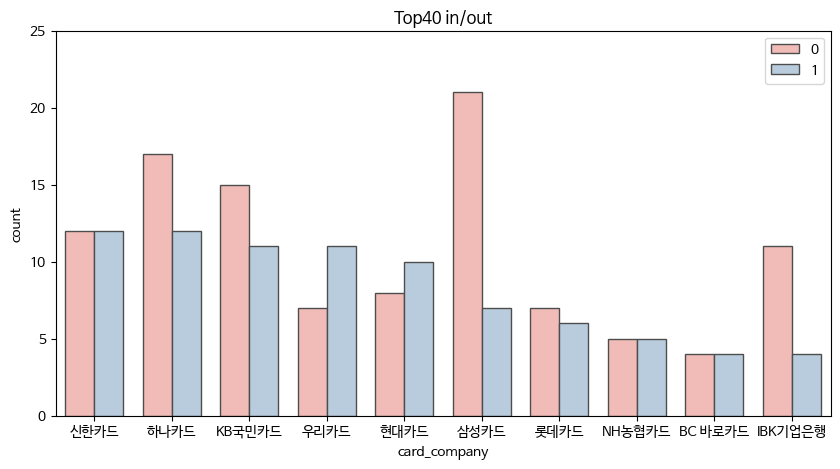

In [ ]:
plt.figure(figsize=(10, 5))

in_cnt = unique_df.groupby(['card_company', 'top40'])['top40'].agg(['count']).reset_index().sort_values(['top40', 'count'], ascending=False)
sns.barplot(data=in_cnt, x='card_company', y='count',
            hue='top40',
            palette=sns.color_palette('Pastel1'),
            edgecolor='.3', width=.75,
            )

plt.legend()
plt.title('Top40 in/out')
plt.yticks(range(0, 30, 5))
plt.show()

### (1) BC 바로카드 위주 분석

#### (1-1) 14개월동안 top100위에 몇 개의 카드, 몇 번 순위권에 등장했을까?

In [ ]:
cards['card_company'].value_counts()

card_company
신한카드       205
삼성카드       203
KB국민카드     188
현대카드       181
하나카드       134
우리카드       129
롯데카드       101
IBK기업은행    101
NH농협카드     100
BC 바로카드     58
Name: count, dtype: int64

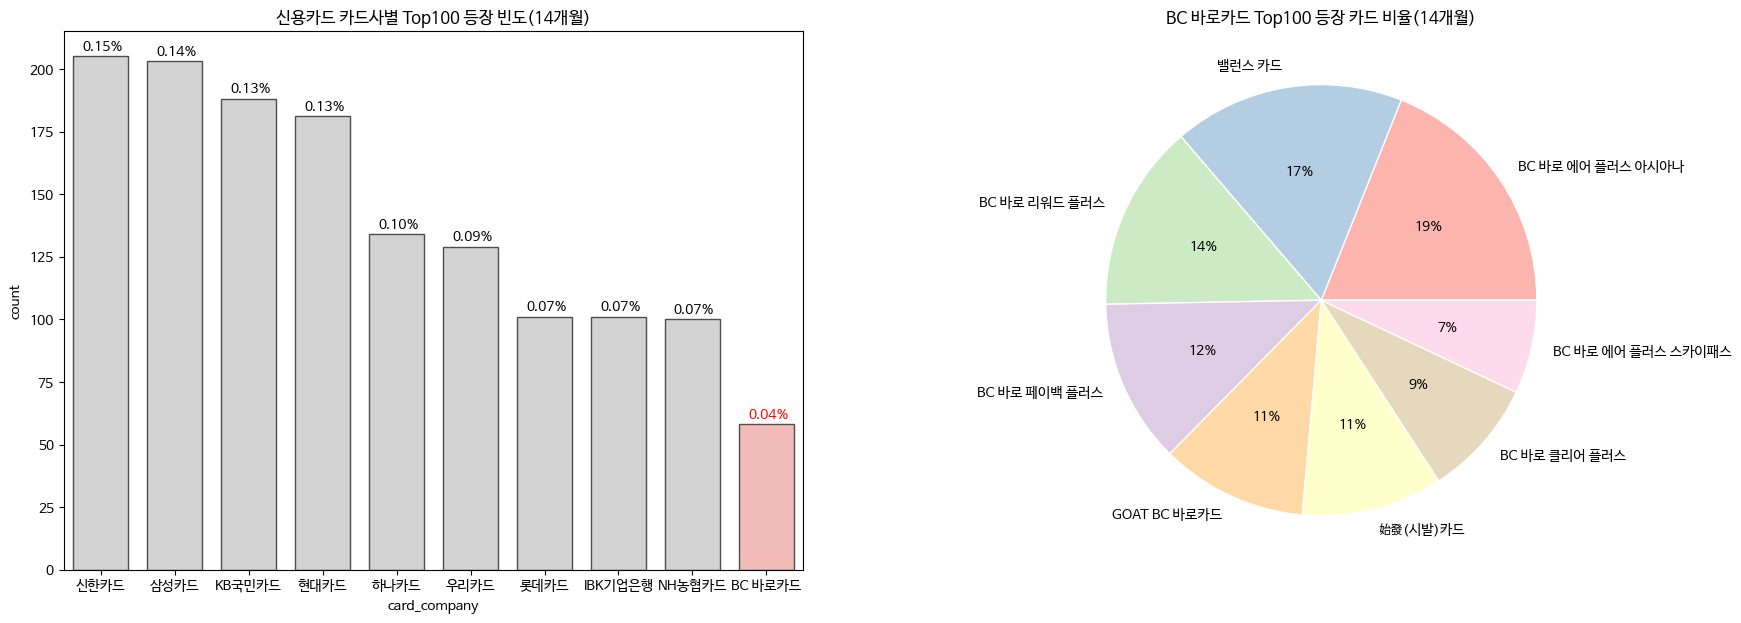

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

d_cnt = pd.DataFrame(cards['card_company'].value_counts()).reset_index()
bc_card = cards[cards['card_company']=='BC 바로카드'].groupby(['card_name'])[['rank']].mean().sort_values('rank', ascending=False)

colors = ['LightGrey', 'LightGrey', 'LightGrey', 'LightGrey', 'LightGrey',
          'LightGrey', 'LightGrey', 'LightGrey', 'LightGrey', sns.color_palette('Pastel1')[0]]
wedgeprops = {'linewidth': 1, 'width':1, 'edgecolor':'w'}

# 전체 카드사 등장 빈도 시각화
sns.barplot(data=d_cnt, x='card_company', y='count',
            # color='LightGrey'
            palette=colors,
            edgecolor='.3', width=.75,
            ax=ax[0]
            )

# BC카드별 등장 빈도 비율 시각화
ax[1].pie(bc_card['rank'],
          labels=bc_card.index.tolist(),
          colors = sns.color_palette('Pastel1'),
          autopct='%.0f%%',
          wedgeprops = wedgeprops,
          )

for p in ax[0].patches:
  if p.get_height() == 58:
    ax[0].text(p.get_x() + (p.get_width())-0.35,
               p.get_y() + p.get_height()+2.5,
               f'{p.get_height()/len(cards):.2f}%',
               ha='center', color='red')
  else:
    ax[0].text(p.get_x() + (p.get_width())-0.35,
               p.get_y() + p.get_height()+2.5,
               f'{p.get_height()/len(cards):.2f}%',
               ha='center', color='black')

ax[0].set_title('신용카드 카드사별 Top100 등장 빈도(14개월)')
ax[1].set_title('BC 바로카드 Top100 등장 카드 비율(14개월)')
plt.show()

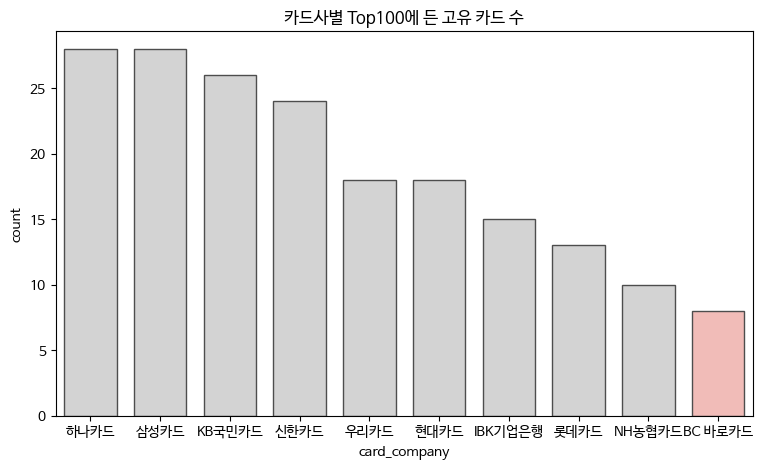

In [ ]:
# 카드사별 Top100에 든 고유 카드 수
plt.figure(figsize=(9, 5))

uni_card = pd.DataFrame(unique_df['card_company'].value_counts()).reset_index()

sns.barplot(data=uni_card, x='card_company', y='count',
            # color='LightGrey'
            palette=colors,
            edgecolor='.3', width=.75,
            ).set_title('카드사별 Top100에 든 고유 카드 수');

> - BC 바로카드가 순위권 등장 빈도가 가장 적음을 알 수 있음 -> 대안 필요  
> - 14개월동안 8개의 카드가 Top100에 등장
>   - https://www.bccard.com/app/card/CreditCardMain.do#
>   - 확인해보면 BC카드의 신용카드 수는 29개인데 이 중 8개만 100위안에 든 것
>   - 근데 발급사가 여러 은행이 있는데 이게 뭐지..? BC 공통 이런 건 뭐지..

#### (1-2) Top100에 등장한 카드 7종의 순위 변화 시각화


- 인기 카드사인 신한, 삼성, KB국민, 현대랑 같이 비교해보기

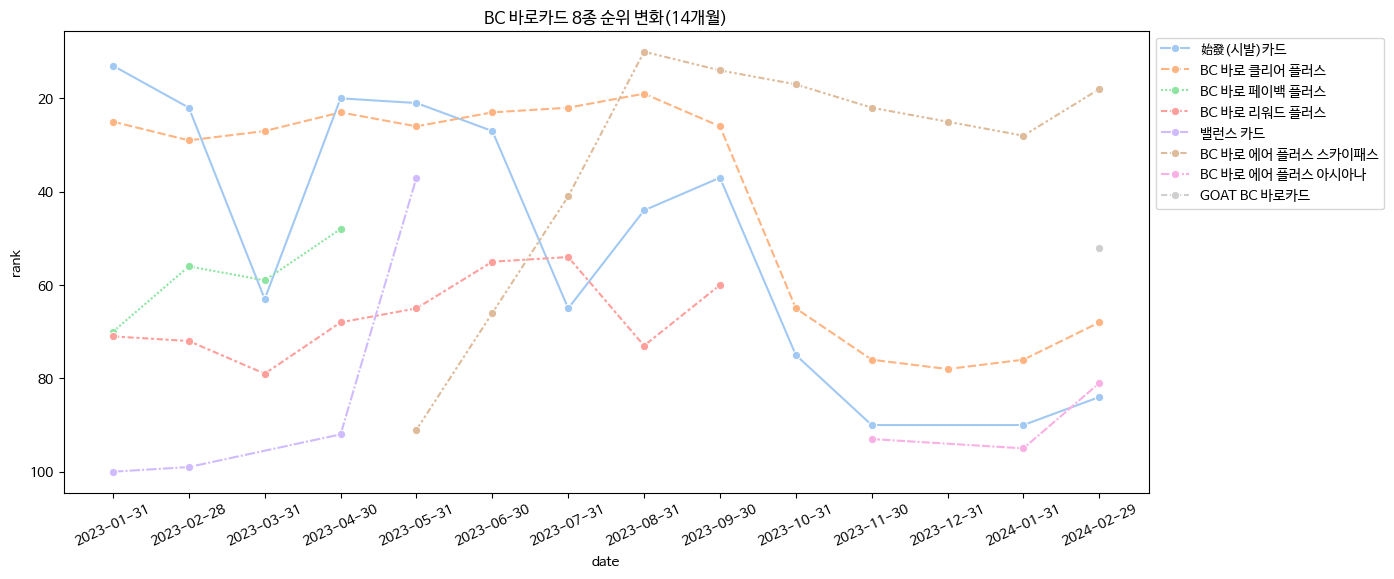

In [ ]:
bc_top = cards[cards['card_company']=='BC 바로카드'][['date', 'rank', 'card_name']]
cnt = len(bc_top['card_name'].unique())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.lineplot(data=bc_top, x='date', y='rank',
             hue='card_name',
             markers='o',
             style='card_name',
             palette=sns.color_palette('pastel'),
             )

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'BC 바로카드 {cnt}종 순위 변화(14개월)')
plt.xticks(rotation=25)
plt.gca().invert_yaxis() # 순위가 작을수록 좋으므로 반전시켜주기
plt.show()

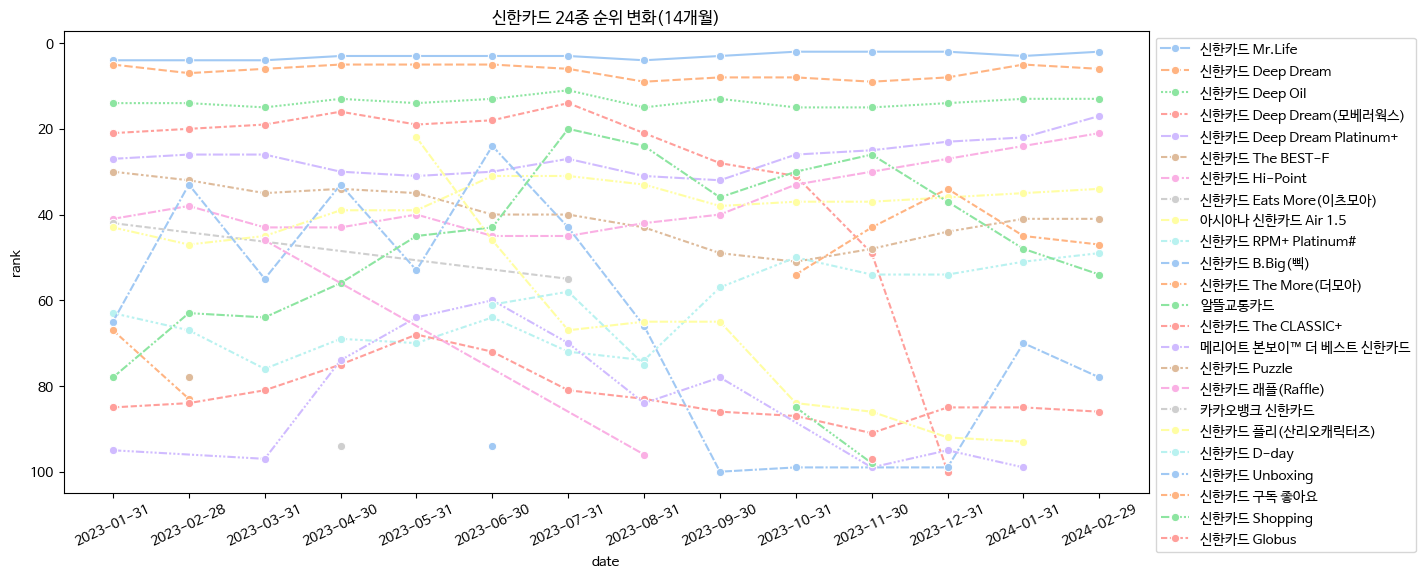

In [ ]:
kb_top = cards[cards['card_company']=='신한카드'][['date', 'rank', 'card_name']]
cnt = len(kb_top['card_name'].unique())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.lineplot(data=kb_top, x='date', y='rank',
             hue='card_name',
             markers='o',
             style='card_name',
             palette=sns.color_palette('pastel'),
             )

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'신한카드 {cnt}종 순위 변화(14개월)')
plt.xticks(rotation=25)
plt.gca().invert_yaxis() # 순위가 작을수록 좋으므로 반전시켜주기
plt.show()

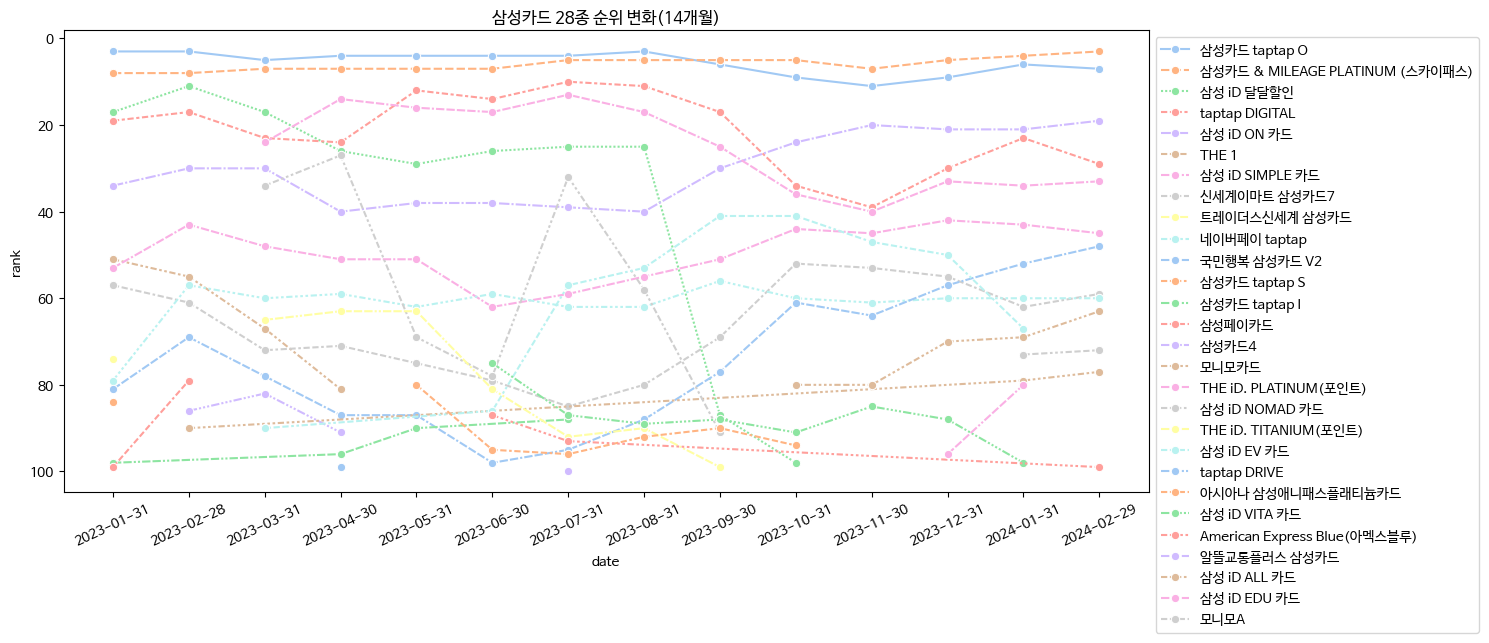

In [ ]:
kb_top = cards[cards['card_company']=='삼성카드'][['date', 'rank', 'card_name']]
cnt = len(kb_top['card_name'].unique())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.lineplot(data=kb_top, x='date', y='rank',
             hue='card_name',
             markers='o',
             style='card_name',
             palette=sns.color_palette('pastel'),
             )

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'삼성카드 {cnt}종 순위 변화(14개월)')
plt.xticks(rotation=25)
plt.gca().invert_yaxis() # 순위가 작을수록 좋으므로 반전시켜주기
plt.show()

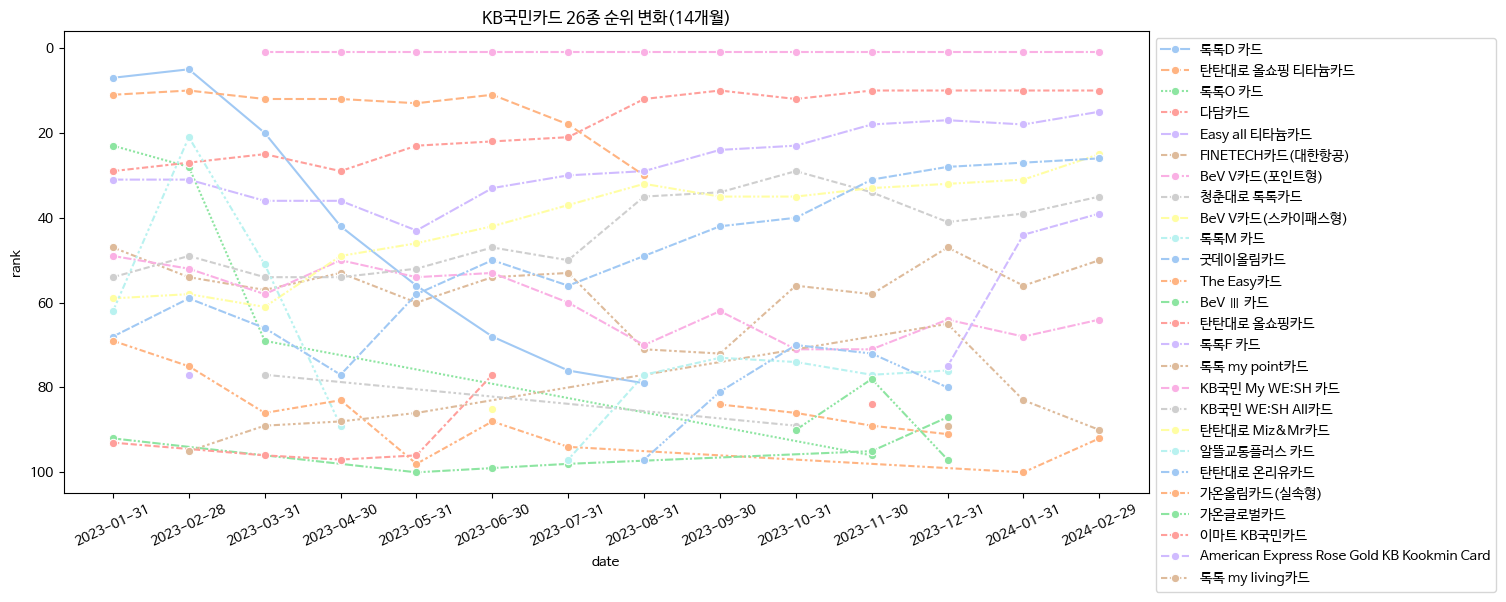

In [ ]:
kb_top = cards[cards['card_company']=='KB국민카드'][['date', 'rank', 'card_name']]
cnt = len(kb_top['card_name'].unique())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.lineplot(data=kb_top, x='date', y='rank',
             hue='card_name',
             markers='o',
             style='card_name',
             palette=sns.color_palette('pastel'),
             )

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'KB국민카드 {cnt}종 순위 변화(14개월)')
plt.xticks(rotation=25)
plt.gca().invert_yaxis() # 순위가 작을수록 좋으므로 반전시켜주기
plt.show()

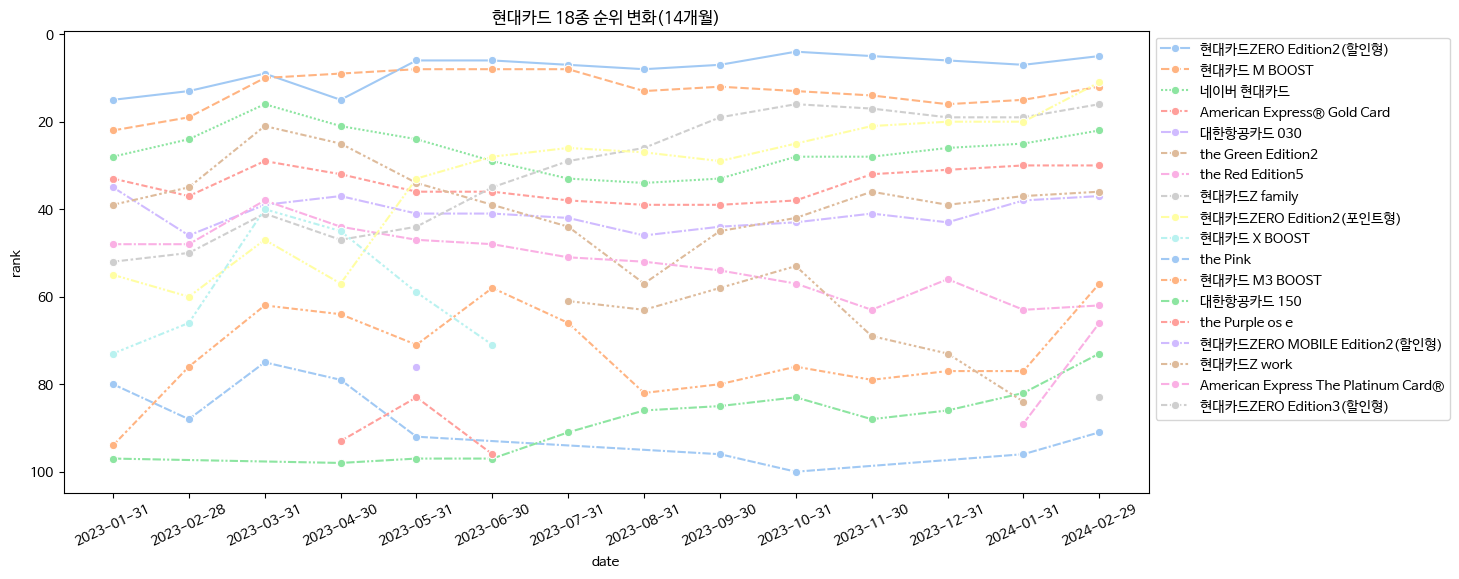

In [ ]:
kb_top = cards[cards['card_company']=='현대카드'][['date', 'rank', 'card_name']]
cnt = len(kb_top['card_name'].unique())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

sns.lineplot(data=kb_top, x='date', y='rank',
             hue='card_name',
             markers='o',
             style='card_name',
             palette=sns.color_palette('pastel'),
             )

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'현대카드 {cnt}종 순위 변화(14개월)')
plt.xticks(rotation=25)
plt.gca().invert_yaxis() # 순위가 작을수록 좋으므로 반전시켜주기
plt.show()

> **4개의 카드사에서 순위권 유지한 카드들**
> - 신한카드: 신한카드 Mr.Life / 신한카드 Deep Dream / 신한카드 Deep Oil
> - 삼성카드: 삼성카드 taptap O / 삼성카드 & MILEAGE PLATINUM (스카이패스)
> - 국민카드: KB국민 My WE:SH 카드 / easy 올 티타늄카드 / 다담카드
> - 현대카드: 현대카드ZERO Edition2(할인형) / 현대카드 M BOOST / 현대카드ZERO Edition3(할인형)

### (2) 4개 카드사 순위권 유지 카드 분석

- 'KB국민카드', '신한카드', '삼성카드', '현대카드'

In [ ]:
c_df = pd.read_csv('/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/credit_card_top100_info.csv')

c_df['perform'] = [text.replace('전월실적', '').replace('만원 이상', '').replace('없음', '').strip() for text in c_df['perform']]
c_df['perform'] = c_df['perform'].replace('', 0)
c_df['perform'] = c_df['perform'].astype('int')
c_df['fee_num'] = c_df['fee_num'].astype('int')

In [ ]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   card_company  173 non-null    object
 1   card_name     173 non-null    object
 2   event         43 non-null     object
 3   promotions    173 non-null    object
 4   fee           173 non-null    object
 5   perform       173 non-null    int64 
 6   brand         173 non-null    object
 7   fee_num       173 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 10.9+ KB


In [ ]:
c_df.describe()

,perform,fee_num
count,173.000000,173.000000
mean,24.017341,49495.375723
std,19.444756,106568.652845
min,0.000000,0.000000
25%,0.000000,10000.000000
50%,30.000000,15000.000000
75%,40.000000,20000.000000
max,50.000000,800000.000000


In [ ]:
len(c_df['fee_num'].value_counts())

39

In [ ]:
c_df.describe(include=[object])

,card_company,card_name,event,promotions,fee,brand
count,173,173,43,173,173,173
unique,10,172,15,171,76,24
top,삼성카드,알뜰교통카드,카드고릴라 프로모션! 신규회원 연회비 100% 캐시백,국내외 가맹점 1%청구할인 && 전월실적 따라 최대 2만원추가할인,국내전용 10000원 해외겸용 10000원,mastercard
freq,24,2,10,2,21,51


In [ ]:
com_4 = unique_df[(unique_df['card_company'].str.contains('KB국민카드|신한카드|삼성카드|현대카드|BC 바로카드') == True)]
com_4 = pd.merge(c_df, com_4, on=['card_company', 'card_name'], how='inner').sort_values('rank_mean').reset_index(drop=True)
com_4

,card_company,card_name,event,promotions,fee,perform,brand,fee_num,rank_mean,freq
0,KB국민카드,KB국민 My WE:SH 카드,KB국민카드 최대 6만원 캐시백,KB Pay 10%할인 && 음식점 10%할인 && 서비스팩 3개 중 1개선택할인,국내전용 15000원 해외겸용 15000원,40,mastercard AMEX,15000,1.0,12.0
1,신한카드,신한카드 Mr.Life,신한카드 이용하고 최대 10만원 캐시백 받아가자!,"공과금 10%할인 && 마트,편의점 10%할인 && 식음료 10%할인",해외겸용 15000원,30,VISA,15000,3.0,14.0
2,삼성카드,삼성카드 taptap O,최대 8만원 캐시백,"스타벅스 50%할인 && 대중교통 10%할인 && CGV, 롯데시네마 5,000원할인",국내전용 10000원 해외겸용 10000원,30,mastercard,10000,5.571429,14.0
3,삼성카드,삼성카드 & MILEAGE PLATINUM (스카이패스),온라인 신규회원 연회비 100% 캐시백,"1,000원당 1마일기본적립 && 커피/주유 2마일특별적립 && 인천공항 라운지무료이용",국내전용 47000원 해외겸용 49000원,0,AMEX,49000,5.928571,14.0
4,신한카드,신한카드 Deep Dream,신한카드 이용하고 최대 10만원 캐시백 받아가자!,모두드림 0.7%적립 && 더해드림 2.1%적립 && 챙겨드림 3.5%적립,해외겸용 8000원,0,VISA UnionPay,8000,6.571429,14.0
...,...,...,...,...,...,...,...,...,...,...
91,신한카드,신한카드 Unboxing,신한카드 이용하고 최대 10만원 받아가자!,"온라인종합몰 10%캐시백 && 편의점 10%캐시백 && 배송비 건당 2,500원할인",국내전용 32000원 해외겸용 35000원,40,AMEX,35000,94.0,1.0
92,KB국민카드,BeV Ⅲ 카드,NaN,포인트리 1.1~1.5%적립 && 전 주유소/충전소 100원/L할인 && 상품권 1...,국내전용 200000원 해외겸용 210000,50,mastercard,210000,95.166667,6.0
93,신한카드,신한카드 Globus,NaN,해외 수수료 1.18%할인 && 국내 이용금액 0.7%적립 && 해외 이용금액 1....,국내전용 22000원 해외겸용 25000원,0,mastercard,25000,97.0,1.0
94,삼성카드,taptap DRIVE,온라인 신규회원 연회비 100% 캐시백,주유 리터당 60~150원할인 && 편의점 10%할인 && 커피전문점 10%할인,국내전용 10000원 해외겸용 10000원,30,VISA,10000,99.0,1.0


#### (2-1) 실적에 따른 순위 분포

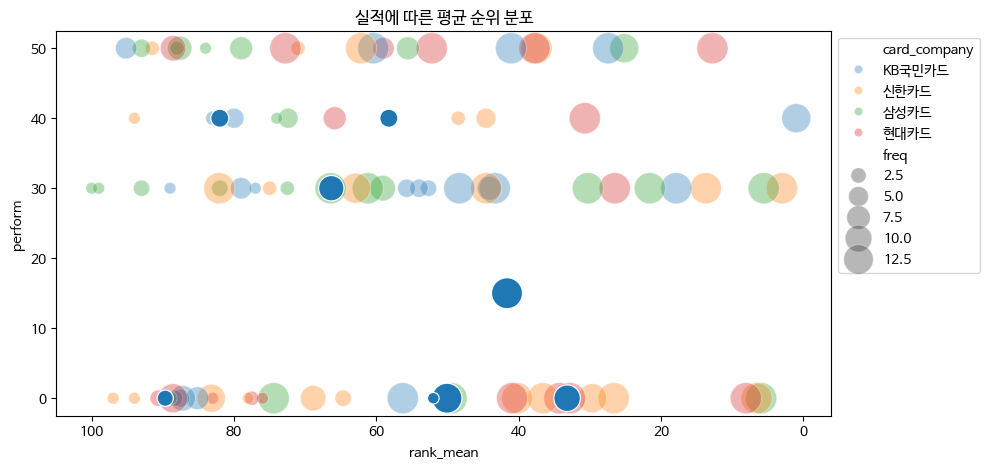

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=com_4[com_4['card_company']!='BC 바로카드'], x="rank_mean", y="perform",
                hue="card_company", size="freq",
                alpha=0.35,
                sizes=(70, 500),
                ).set_title('실적에 따른 평균 순위 분포')
sns.scatterplot(data=com_4[com_4['card_company']=='BC 바로카드'],
                x="rank_mean", y="perform",
                hue="card_company", size="freq",
                # alpha=0.35,
                color='black', sizes=(70, 500),
                legend=False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_xaxis()

#### (2-2) 연회비에 따른 순위 분포

[None]

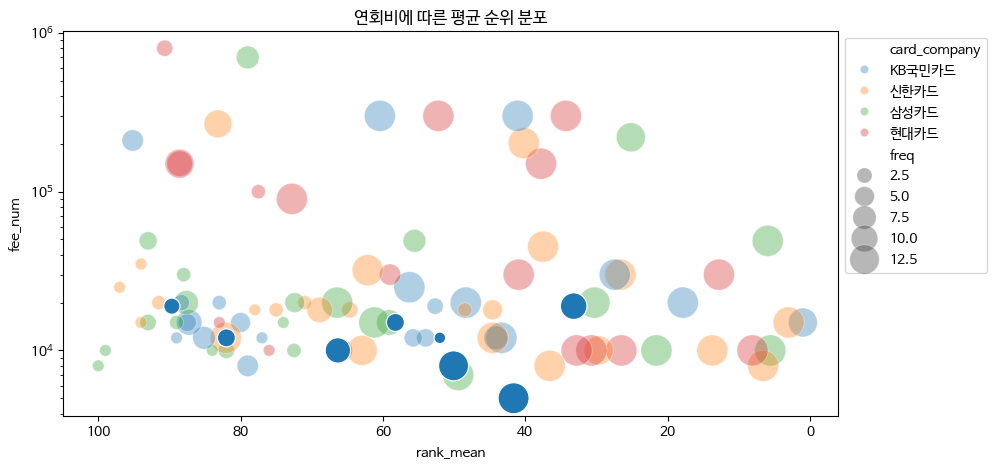

In [ ]:
plt.figure(figsize=(10, 5))
pp = sns.scatterplot(data=com_4[com_4['card_company']!='BC 바로카드'],
                     x="rank_mean", y="fee_num",
                     hue="card_company", size="freq",
                     alpha=0.35,
                     sizes=(70, 500),
                     )
sns.scatterplot(data=com_4[com_4['card_company']=='BC 바로카드'],
                x="rank_mean", y="fee_num",
                hue="card_company", size="freq",
                # alpha=0.35,
                color='red', sizes=(70, 500),
                legend=False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_xaxis()
pp.set_title('연회비에 따른 평균 순위 분포')
pp.set(yscale="log")

## 2) Top100 등장 카드 정보 분석

- 프로모션 텍스트 전처리 필요 -> &&로 구분해서 수집해두긴 했는데..
  - 할인에 따라서 분석해보려면 섬세한 전처리 필요..
  - 빈도수에 따른 분석은 워드클라우드?
- 연회비 국내 해외 split
  - int형으로 변환해서 실적이랑 scatterplot 확인해봐도 ㄱㅊ을지도..
- 실적 int형으로 변환

In [ ]:
card_info = pd.merge(c_df, unique_df, on=['card_company', 'card_name'], how='inner')
card_info.head()

,card_company,card_name,event,promotions,fee,perform,brand,fee_num,rank_mean,freq,top40_mean,top40
0,롯데카드,LOCA 365 카드,NaN,"아파트관리비, 공과금 10%할인 && 교통, 통신, 배달앱 10%할인 && 스트리밍...",국내전용 20000원 해외겸용 20000원,50,mastercard AMEX,20000,2.785714,14.0,1.0,1
1,우리카드,DA@카드의정석,NaN,모든가맹점 0.8%할인 && 생활업종 1.3%할인 && 국내공항라운지 연 2회무료(...,국내전용 5000원 해외겸용 10000원,0,BC mastercard,10000,6.928571,14.0,1.0,1
2,삼성카드,삼성카드 taptap O,최대 8만원 캐시백,"스타벅스 50%할인 && 대중교통 10%할인 && CGV, 롯데시네마 5,000원할인",국내전용 10000원 해외겸용 10000원,30,mastercard,10000,5.571429,14.0,1.0,1
3,신한카드,신한카드 Mr.Life,신한카드 이용하고 최대 10만원 캐시백 받아가자!,"공과금 10%할인 && 마트,편의점 10%할인 && 식음료 10%할인",해외겸용 15000원,30,VISA,15000,3.0,14.0,1.0,1
4,신한카드,신한카드 Deep Dream,신한카드 이용하고 최대 10만원 캐시백 받아가자!,모두드림 0.7%적립 && 더해드림 2.1%적립 && 챙겨드림 3.5%적립,해외겸용 8000원,0,VISA UnionPay,8000,6.571429,14.0,1.0,1


In [ ]:
card_info[card_info['top40']==0][['card_company', 'card_name']].value_counts()

card_company  card_name                     
BC 바로카드       BC 바로 리워드 플러스                     1
우리카드          카드의정석 PREMIUM MILEAGE(SKYPASS)    1
              SKT 우리카드                          1
              Diners Club MILEAGE               1
              DA카드의정석 Ⅱ                         1
                                               ..
NH농협카드        별다줄카드                             1
              zgm.휴가중카드                         1
              zgm.the pay카드                     1
              NH올원 Shopping&11번가카드(R2타입)        1
현대카드          현대카드ZERO MOBILE Edition2(할인형)     1
Name: count, Length: 98, dtype: int64

In [ ]:
card_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   card_company  173 non-null    object
 1   card_name     173 non-null    object
 2   event         43 non-null     object
 3   promotions    173 non-null    object
 4   fee           173 non-null    object
 5   perform       173 non-null    int64 
 6   brand         173 non-null    object
 7   fee_num       173 non-null    int64 
 8   rank_mean     173 non-null    object
 9   freq          173 non-null    object
 10  top50_mean    173 non-null    object
dtypes: int64(2), object(9)
memory usage: 15.0+ KB


### (1) Top100 중 rank 평균이 50 이하인 카드

- BC 바로카드와 비교

In [ ]:
top_40 = card_info[card_info['top40']==1].reset_index(drop=True)
print(len(top_40))
top_40.head()

75


,card_company,card_name,event,promotions,fee,perform,brand,fee_num,rank_mean,freq,top40_mean,top40
0,롯데카드,LOCA 365 카드,NaN,"아파트관리비, 공과금 10%할인 && 교통, 통신, 배달앱 10%할인 && 스트리밍...",국내전용 20000원 해외겸용 20000원,50,mastercard AMEX,20000,2.785714,14.0,1.0,1
1,우리카드,DA@카드의정석,NaN,모든가맹점 0.8%할인 && 생활업종 1.3%할인 && 국내공항라운지 연 2회무료(...,국내전용 5000원 해외겸용 10000원,0,BC mastercard,10000,6.928571,14.0,1.0,1
2,삼성카드,삼성카드 taptap O,최대 8만원 캐시백,"스타벅스 50%할인 && 대중교통 10%할인 && CGV, 롯데시네마 5,000원할인",국내전용 10000원 해외겸용 10000원,30,mastercard,10000,5.571429,14.0,1.0,1
3,신한카드,신한카드 Mr.Life,신한카드 이용하고 최대 10만원 캐시백 받아가자!,"공과금 10%할인 && 마트,편의점 10%할인 && 식음료 10%할인",해외겸용 15000원,30,VISA,15000,3.0,14.0,1.0,1
4,신한카드,신한카드 Deep Dream,신한카드 이용하고 최대 10만원 캐시백 받아가자!,모두드림 0.7%적립 && 더해드림 2.1%적립 && 챙겨드림 3.5%적립,해외겸용 8000원,0,VISA UnionPay,8000,6.571429,14.0,1.0,1


In [ ]:
from tqdm import tqdm

top_40['promotions_nlp'] = [txt.replace('&&','').replace(',', '').replace('%', '') for txt in top_40['promotions']]

text = ''
for txt in tqdm(top_40['promotions_nlp']):
    text += txt
    text += ' '

100%|██████████| 75/75 [00:00<00:00, 247695.12it/s]


In [ ]:
tokenizer = RegexpTokenizer("[\w]{3,}")
reg_text = tokenizer.tokenize(text)

lemmatizer = WordNetLemmatizer()
lemreg_text = [lemmatizer.lemmatize(token, pos = 'v') for token in reg_text]

print(len(lemreg_text))
print(lemreg_text[:50])

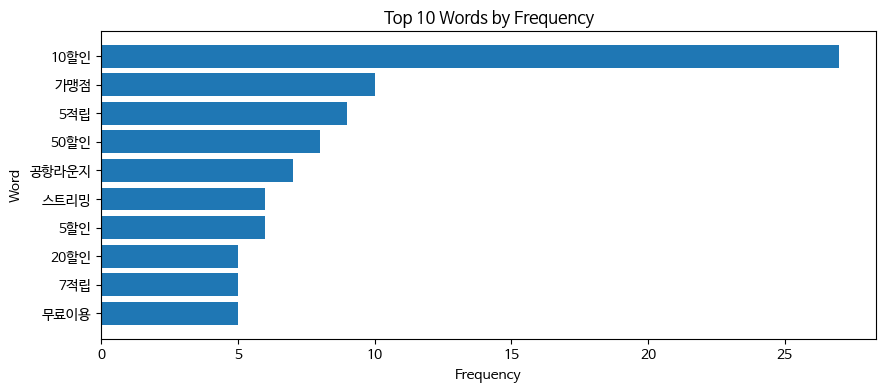

In [ ]:
from collections import Counter

word_freq = Counter(lemreg_text)
word_freq_df = pd.DataFrame(word_freq.items(), columns = ['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by = 'Frequency', ascending = False)

top_20 = word_freq_df.head(10)
top_20 = top_20[::-1]

plt.figure(figsize=(10,4))
plt.barh(top_20['Word'], top_20['Frequency'])

plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Words by Frequency')
plt.show()

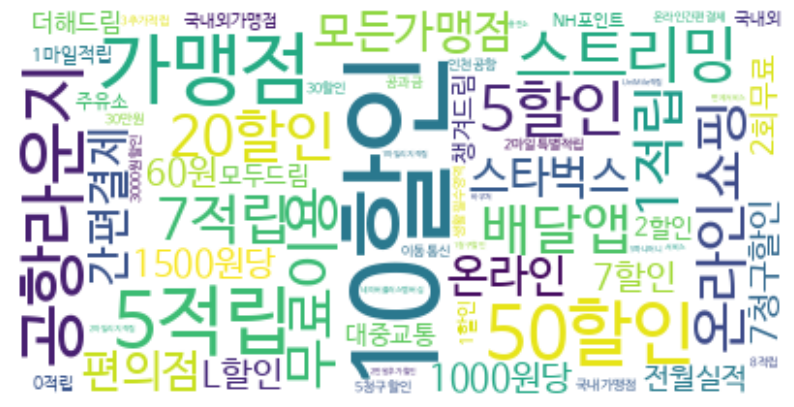

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color = "white",
               max_words = 100,
               max_font_size = 60,
               font_path='NanumBarunGothic'
               )
wc.generate_from_frequencies(word_freq)

plt.figure(figsize = (10, 6))
plt.axis("off")
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

### (2) 전체 등장 카드

### chart in/out

In [ ]:
import nltk
nltk.download('gutenberg') #60,000 novels available
from nltk.corpus import gutenberg
file_names = gutenberg.fileids() #import novel titles
print(file_names)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [ ]:
card_info['promotions_nlp'] = [txt.replace('&&','').replace(',', '').replace('%', '') for txt in card_info['promotions']]

in_df = card_info[card_info['top40']==1].reset_index(drop=True)
out_df = card_info[card_info['top40']==0].reset_index(drop=True)
print(len(in_df), len(out_df))

75 98


In [ ]:
text_in, text_out = '', ''

for txt in tqdm(in_df['promotions_nlp']):
    text_in += txt
    text_in += ' '

for txt in tqdm(out_df['promotions_nlp']):
    text_out += txt
    text_out += ' '

100%|██████████| 98/98 [00:00<00:00, 235149.77it/s]


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer("[\w]{3,}")
reg_text_in = tokenizer.tokenize(text_in)
reg_text_out = tokenizer.tokenize(text_out)

lemmatizer = WordNetLemmatizer()
lemreg_text_in = [lemmatizer.lemmatize(token, pos = 'v') for token in reg_text_in]
lemreg_text_out = [lemmatizer.lemmatize(token, pos = 'v') for token in reg_text_out]

print(len(lemreg_text_in), len(lemreg_text_out))
print(lemreg_text_in[:50])
print(lemreg_text_out[:50])

474 606
['아파트관리비', '공과금', '10할인', '배달앱', '10할인', '스트리밍', '1500원할인', '모든가맹점', '8할인', '생활업종', '3할인', '국내공항라운지', '2회무료', '전월실적', '30만원', '스타벅스', '50할인', '대중교통', '10할인', 'CGV', '롯데시네마', '5000원할인', '공과금', '10할인', '마트편의점', '10할인', '식음료', '10할인', '모두드림', '7적립', '더해드림', '1적립', '챙겨드림', '5적립', '국내가맹점', '1적립', '플러스적립', '5000머니적립', 'SK주유소', '3000원할인', '배달앱', '50할인', '온라인', '간편결제', '10할인', '편의점', '5할인', '1000원당', '1마일기본적립', '2마일특별적립']
['전가맹점', '결제금액', '1천원미만기본적립', '추가적립업종', '1600P추가적립', '환전수수료', '면제서비스', '1500원당', '30마일적립', '공항라운지', '2회무료', '스타벅스', '2천원할인', '국내이용', '2마일적립', '해외이용', '2마일적립', '3마일적립', '포인트리', '0적립', '프리미엄쿠폰', '1회제공', '공항라운지', '무료이용서비스', '11번가', '22할인', '온라인쇼핑', '7할인', '10할인', '가맹점', '1할인', '온라인쇼핑몰', '멤버십', '50할인', '3000원할인', '신세계백화점', '5할인', '이마트', '6000원할인', '국내가맹점', '3적립', '대중교통', '200원할인', '10000원할인', '커피전문점', '20할인', '오프라인쇼핑', '10할인', '간편결제', '5추가할인']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


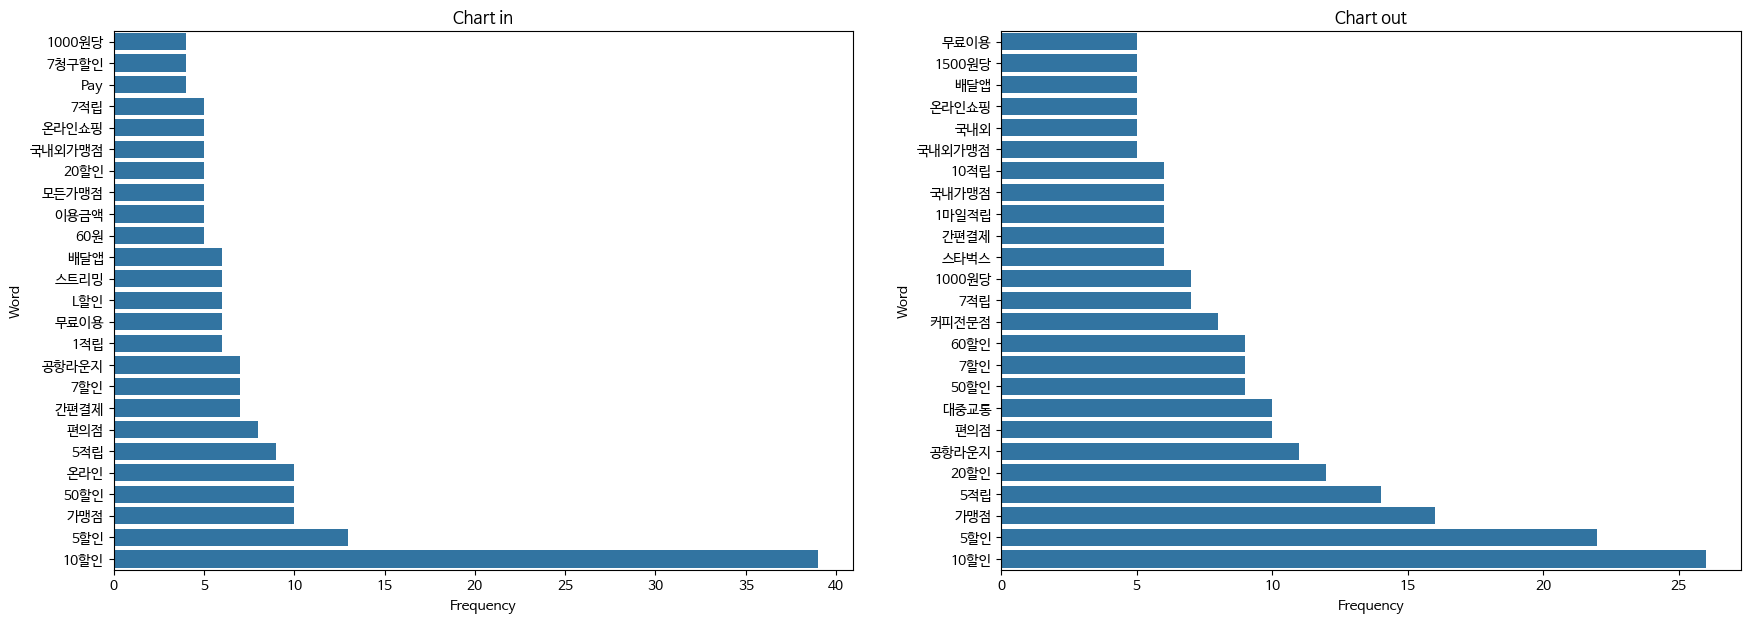

In [ ]:
from collections import Counter

word_freq_in = Counter(lemreg_text_in)
word_freq_out = Counter(lemreg_text_out)

in_freq_df = pd.DataFrame(word_freq_in.items(), columns = ['Word', 'Frequency'])
in_freq_df = in_freq_df.sort_values(by = 'Frequency', ascending = False)
out_freq_df = pd.DataFrame(word_freq_out.items(), columns = ['Word', 'Frequency'])
out_freq_df = out_freq_df.sort_values(by = 'Frequency', ascending = False)

in_40 = in_freq_df.head(25)
in_40 = in_40[::-1]
out_40 = out_freq_df.head(25)
out_40 = out_40[::-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

sns.barplot(data=in_40, y='Word', x='Frequency',
            ax=ax[0]).set_title('Chart in')
sns.barplot(data=out_40, y='Word', x='Frequency',
            ax=ax[1]).set_title('Chart out')

plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

#### (2-1-1) 혜택_워드클라우드

- 우선 워드 클라우드 정도만

In [ ]:
card_info['promotions_nlp'] = [txt.replace('&&','').replace(',', '').replace('%', '') for txt in card_info['promotions']]

text = ''
for txt in tqdm(card_info['promotions_nlp']):
    text += txt
    text += ' '

100%|██████████| 173/173 [00:00<00:00, 187934.37it/s]


In [ ]:
tokenizer = RegexpTokenizer("[\w]{3,}")
reg_text = tokenizer.tokenize(text)

lemmatizer = WordNetLemmatizer()
lemreg_text = [lemmatizer.lemmatize(token, pos = 'v') for token in reg_text]

print(len(lemreg_text))
print(lemreg_text[:50])

[nltk_data] Downloading package wordnet to /root/nltk_data...


1080
['아파트관리비', '공과금', '10할인', '배달앱', '10할인', '스트리밍', '1500원할인', '모든가맹점', '8할인', '생활업종', '3할인', '국내공항라운지', '2회무료', '전월실적', '30만원', '스타벅스', '50할인', '대중교통', '10할인', 'CGV', '롯데시네마', '5000원할인', '공과금', '10할인', '마트편의점', '10할인', '식음료', '10할인', '모두드림', '7적립', '더해드림', '1적립', '챙겨드림', '5적립', '국내가맹점', '1적립', '플러스적립', '5000머니적립', 'SK주유소', '3000원할인', '배달앱', '50할인', '온라인', '간편결제', '10할인', '편의점', '5할인', '1000원당', '1마일기본적립', '2마일특별적립']


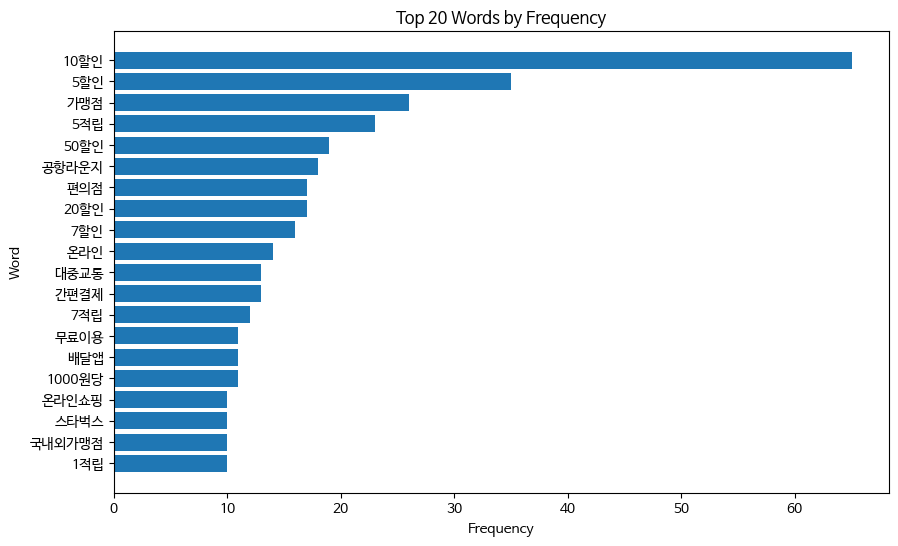

In [ ]:
from collections import Counter

word_freq = Counter(lemreg_text)
word_freq_df = pd.DataFrame(word_freq.items(), columns = ['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by = 'Frequency', ascending = False)

top_20 = word_freq_df.head(20)
top_20 = top_20[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_20['Word'], top_20['Frequency'])

plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Words by Frequency')
plt.show()

In [ ]:
# !pip install wordcloud

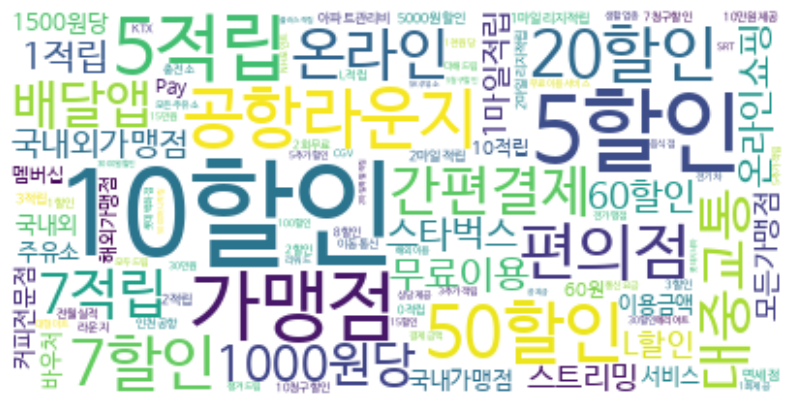

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color = "white",
               max_words = 100,
               max_font_size = 60,
               font_path='NanumBarunGothic'
               )
wc.generate_from_frequencies(word_freq)

plt.figure(figsize = (10, 6))
plt.axis("off")
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

> - 업종은 가맹점, 공항라운지, 대중교통, 배달앱, 편의점, 카페가 눈에 띔
> - 적용 혜택에서 할인은 5\~50%할인 적용이, 적립은 5\~7적립, 무료이용이 눈에 띔

#### (2-1-2) 혜택_종류별 분석

- 적립형인지 할인형인지
- 카테고리
  - 가맹점
  - 공항라운지
  - 편의점
  - 온라인(쇼핑+간편결제)
  - 대중교통+주유
  - 배달앱
  - 카페
  - 스트리밍
  - 의료/교육

In [ ]:
print(len(card_info))
card_info.head(2)

172


,card_company,card_name,event,promotions,fee,perform,brand,fee_num,rank_mean,freq
0,롯데카드,LOCA 365 카드,NaN,"아파트관리비, 공과금 10%할인 && 교통, 통신, 배달앱 10%할인 && 스트리밍...",국내전용 20000원 해외겸용 20000원,50,mastercard AMEX,20000,2.785714,14.0
1,우리카드,DA@카드의정석,NaN,모든가맹점 0.8%할인 && 생활업종 1.3%할인 && 국내공항라운지 연 2회무료(...,국내전용 5000원 해외겸용 10000원,0,BC mastercard,10000,6.928571,14.0


In [ ]:
card_info['point'] = 0
card_info['franchisee'] = 0
card_info['air_lounge'] = 0
card_info['convenience_store'] = 0
card_info['online'] = 0
card_info['transportation'] = 0
card_info['delivery'] = 0
card_info['cafe'] = 0
card_info['streaming'] = 0
card_info['medical_edu'] = 0

In [ ]:
# point
print(len(card_info[card_info['promotions'].str.contains('적립')==True]))
card_info.loc[card_info['promotions'].str.contains('적립')==True, 'point'] = 1

# franchisee
print(len(card_info[card_info['promotions'].str.contains('가맹|가맹점|업종별')==True]))
card_info.loc[card_info['promotions'].str.contains('가맹|가맹점|업종별')==True, 'franchisee'] = 1

# delivery
print(len(card_info[card_info['promotions'].str.contains('배달')==True]))
card_info.loc[card_info['promotions'].str.contains('배달')==True, 'delivery'] = 1

# convenience_store
print(len(card_info[card_info['promotions'].str.contains('편의점|생활업종|마트')==True]))
card_info.loc[card_info['promotions'].str.contains('편의점|생활업종|마트')==True, 'convenience_store'] = 1

# air_lounge
len(card_info[card_info['promotions'].str.contains('라운지|공항')==True])
card_info.loc[card_info['promotions'].str.contains('라운지|공항')==True, 'air_lounge'] = 1

# streaming
print(len(card_info[card_info['promotions'].str.contains('구독|스트리밍|OTT')==True]))
card_info.loc[card_info['promotions'].str.contains('구독|스트리밍|OTT')==True, 'streaming'] = 1

# cafe
print(len(card_info[card_info['promotions'].str.contains('카페|스타벅스|커피|베이커리')==True]))
card_info.loc[card_info['promotions'].str.contains('카페|스타벅스|커피|베이커리')==True, 'cafe'] = 1

# online
print(len(card_info[card_info['promotions'].str.contains('온|온라인|간편결제|간편 결제')==True]))
card_info.loc[card_info['promotions'].str.contains('온|온라인|간편결제|간편 결제')==True, 'online'] = 1

# transportation
print(len(card_info[card_info['promotions'].str.contains('주유|버스|교통|지하철|KTX|SRT|택시|전기차|LPG')==True]))
card_info.loc[card_info['promotions'].str.contains('주유|버스|교통|지하철|KTX|SRT|택시|전기차|LPG')==True, 'transportation'] = 1

# medical_edu
print(len(card_info[card_info['promotions'].str.contains('병원|의료|교육|학원')==True]))
card_info.loc[card_info['promotions'].str.contains('병원|의료|교육|학원')==True, 'medical_edu'] = 1

# save
# card_info.to_csv('/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/preprocessing_info.csv', index=False)

79


In [ ]:
card_info = pd.read_csv('/content/gdrive/MyDrive/비즈니스애널리틱스/project_data/preprocessing_info.csv')
card_info.head(1)

,card_company,card_name,event,promotions,fee,perform,brand,fee_num,rank_mean,freq,point,franchisee,air_lounge,convenience_store,online,transportation,delivery,cafe,streaming,medical_edu
0,롯데카드,LOCA 365 카드,NaN,"아파트관리비, 공과금 10%할인 && 교통, 통신, 배달앱 10%할인 && 스트리밍...",국내전용 20000원 해외겸용 20000원,50,mastercard AMEX,20000,2.785714,14.0,0,0,0,0,0,1,1,0,1,0


In [ ]:
card_info.describe()

,perform,fee_num,rank_mean,freq,point,franchisee,air_lounge,convenience_store,online,transportation,delivery,cafe,streaming,medical_edu
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,24.040698,49666.860465,60.127707,7.732558,0.459302,0.302326,0.145349,0.168605,0.220930,0.267442,0.075581,0.197674,0.087209,0.052326
std,19.499095,106855.861300,25.954447,5.211154,0.499796,0.460606,0.353481,0.375496,0.416085,0.443917,0.265099,0.399408,0.282965,0.223333
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10000.000000,41.035714,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,15000.000000,65.119048,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.000000,21250.000000,82.000000,14.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,50.000000,800000.000000,100.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
display(card_info.groupby(['point'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['franchisee'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['air_lounge'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['convenience_store'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['online'])[['rank_mean', 'freq']].agg(['mean', 'count']))

rank_mean            freq      
            mean count      mean count
point                                 
0      61.021037    93  6.913978    93
1      59.076065    79  8.696203    79

rank_mean            freq      
                 mean count      mean count
franchisee                                 
0           60.542503   120  7.766667   120
1           59.170487    52  7.653846    52

rank_mean            freq      
                 mean count      mean count
air_lounge                                 
0           61.048681   147  7.578231   147
1           54.712381    25  8.640000    25

rank_mean            freq      
                        mean count      mean count
convenience_store                                 
0                  59.937009   143  7.895105   143
1                  61.068047    29  6.931034    29

rank_mean            freq      
             mean count      mean count
online                                 
0       60.491607   134  7.664179   134
1       58.844483    38  7.973684    38

In [ ]:
display(card_info.groupby(['transportation'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['delivery'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['cafe'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['streaming'])[['rank_mean', 'freq']].agg(['mean', 'count']))
display(card_info.groupby(['medical_edu'])[['rank_mean', 'freq']].agg(['mean', 'count']))

rank_mean            freq      
                     mean count      mean count
transportation                                 
0               60.066410   126  7.333333   126
1               60.295608    46  8.826087    46

rank_mean            freq      
               mean count      mean count
delivery                                 
0         59.978568   159  7.735849   159
1         61.951796    13  7.692308    13

rank_mean            freq      
           mean count      mean count
cafe                                 
0     59.499906   138  8.094203   138
1     62.675840    34  6.264706    34

rank_mean            freq      
                mean count      mean count
streaming                                 
0          60.956681   157  7.713376   157
1          51.451111    15  7.933333    15

rank_mean            freq      
                  mean count      mean count
medical_edu                                 
0            59.317018   163  7.865031   163
1            74.810185     9  5.333333     9

#### (2-2) 연회비

<Axes: xlabel='card_company', ylabel='fee_num'>

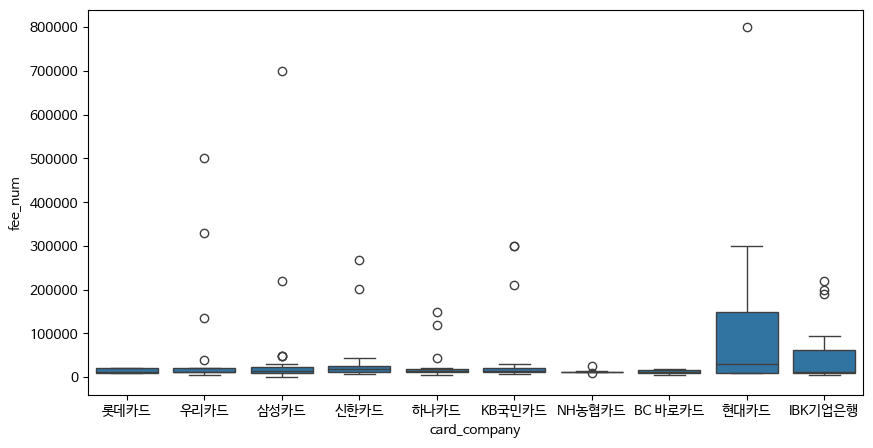

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=card_info, x='card_company', y='fee_num')

Text(0.5, 1.0, '카드별 연회비에 따른 순위평균 분포')

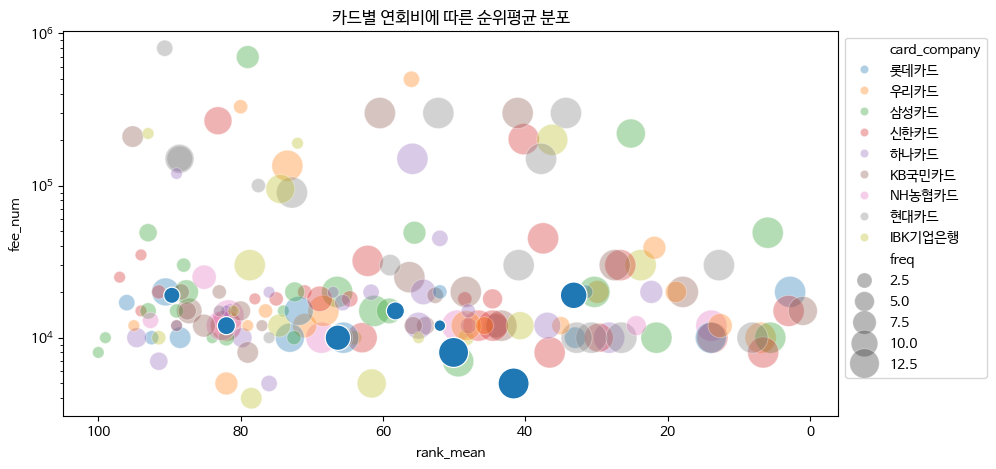

In [ ]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(data=card_info[card_info['card_company']!='BC 바로카드'],
                    x="rank_mean", y="fee_num",
                    hue="card_company", size="freq",
                    alpha=0.35,
                    sizes=(70, 500),
                    )
sns.scatterplot(data=card_info[card_info['card_company']=='BC 바로카드'],
                x="rank_mean", y="fee_num",
                hue="card_company", size="freq",
                # alpha=0.35,
                color='red', sizes=(70, 500),
                legend=False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_xaxis()
g.set(yscale="log")
g.set_title('카드별 연회비에 따른 순위평균 분포')

#### (2-3) 실적

Text(0.5, 1.0, '카드별 실적에 따른 순위평균 분포')

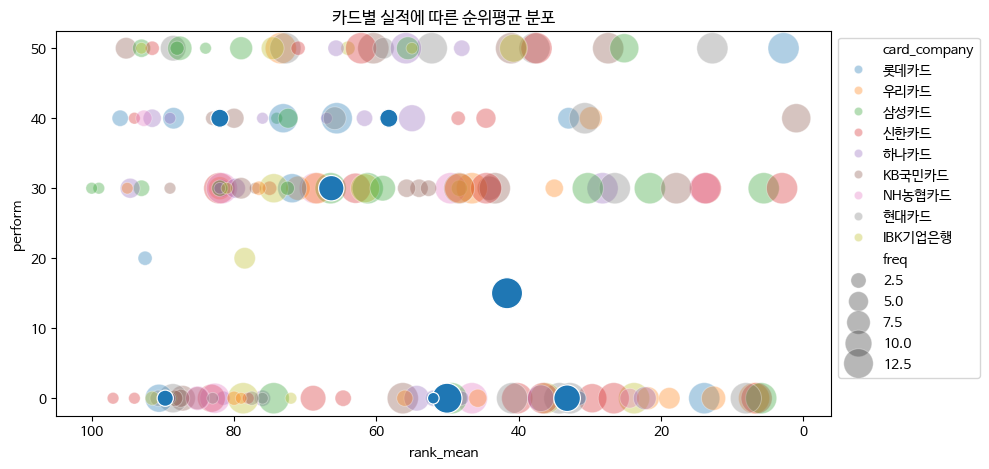

In [ ]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(data=card_info[card_info['card_company']!='BC 바로카드'],
                    x="rank_mean", y="perform",
                    hue="card_company", size="freq",
                    alpha=0.35,
                    sizes=(70, 500),
                    )
sns.scatterplot(data=card_info[card_info['card_company']=='BC 바로카드'],
                x="rank_mean", y="perform",
                hue="card_company", size="freq",
                # alpha=0.35,
                color='red', sizes=(70, 500),
                legend=False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_xaxis()
g.set_title('카드별 실적에 따른 순위평균 분포')